In [37]:
import importlib
from dkst.utils import KST_utils, DKST_utils, set_operations, relations
from dkst import dkst_datasets, models

# Import everything from the modules
from dkst.utils.KST_utils import *
from dkst.utils.DKST_utils import *
from dkst.utils.set_operations import *
from dkst.utils.relations import *
from dkst.dkst_datasets import *
from dkst.models import *

from torch.utils.data import DataLoader
print("Modules imported successfully.")

config_path = os.path.abspath("../data/config/config_data_06.json")
model_path = os.path.abspath("../data/models/model_Q6_01.pth")

Modules imported successfully.


In [ ]:
#tmp_path = os.path.abspath("../data/datasets/dataset_train_Q6_50.pth")
#D_train = torch.load(tmp_path, weights_only=False)   # Trainingset was too big to upload to GitHub... 
tmp_path = os.path.abspath("../data/datasets/dataset_test_Q6_50.pth")
D_test = torch.load(tmp_path, weights_only=False)
    


Batch size:  4
Shape conditionals:        torch.Size([4, 64])
Shape input sequence:      torch.Size([4, 64])
Shape target sequence:     torch.Size([4, 64])
Shape input observations:  torch.Size([4, 64])
Conditionals histogram:


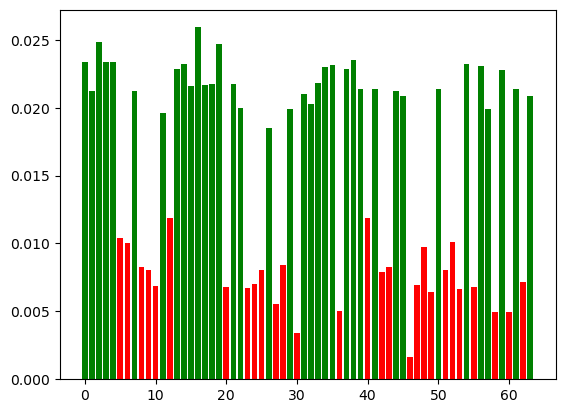

Input observations histogram:


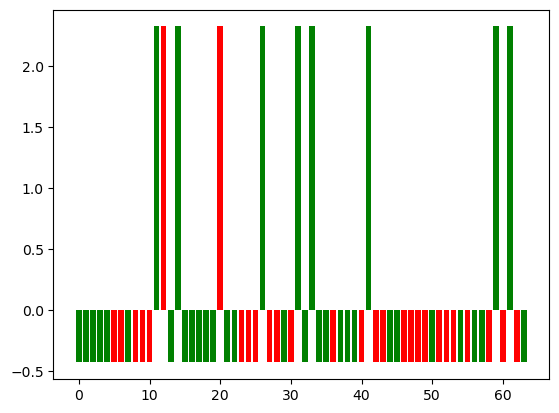


Output shape:  torch.Size([64, 4, 65])
Embedding shape:  torch.Size([4, 1024])



In [47]:
# model
model = CustomDecoderModel(config_path)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
device = model.config["device"]
model = model.to(device)

dataloader = DataLoader(D_test, batch_size=4, shuffle=True, collate_fn=collate_fn)
device = "mps"
# get one batch 
for i_batch, sample_batched in enumerate(dataloader):
    print()
    print("Batch size: ", len(sample_batched))
    print("Shape conditionals:       ", sample_batched[0].shape)
    print("Shape input sequence:     ", sample_batched[1].shape) 
    print("Shape target sequence:    ", sample_batched[2].shape) 
    print("Shape input observations: ", sample_batched[3].shape)

    # Histogram to vizualize conditionals
    conditionals = sample_batched[0].numpy()[0]
    colors = ['green' if i in sample_batched[2][0] else 'red' for i in range(len(conditionals))]
    colors[0] = 'green'
    print("Conditionals histogram:")
    plt.bar(range(len(conditionals)), conditionals.flatten(), color=colors)
    plt.show()

    # Histogram to vizualize input observations
    input_obs = sample_batched[3].numpy()[0]
    print("Input observations histogram:")
    plt.bar(range(len(input_obs)), input_obs.flatten(), color=colors)
    plt.show()
    break

for i_batch, sample_batched in enumerate(dataloader):
    conditionals, input_seq, target_seq, input_obs = sample_batched
    conditionals = conditionals.to(device)
    input_seq = input_seq.to(device)
    target_seq = target_seq.to(device)
    input_obs = input_obs.to(device)
    output, embedding, attention_weights = model.forward(conditionals, input_seq)
    print()
    print("Output shape: ", output.shape) 
    print("Embedding shape: ", embedding.shape)
    print()
    break
    

In [ ]:
for i in range(5):
    dataloader = DataLoader(D_test, batch_size=1, shuffle=True, collate_fn=collate_fn)
    for conditionals, input_seq, target_seq, input_obs in dataloader:
        break  # We only need one sample
    conditionals = conditionals.to(device)
    input_seq = input_seq.to(device)
    input_obs = input_obs.to(device)

    seq, emb = generate_sequence(model, conditionals.to(device), device=device, data_embedding=None)
    seq_MCDP, emb_MCDP = generate_sequence_MCDP(model, conditionals.to(device), device=device, data_embedding=None)
    print("Target sequence:    ", [t for t in [0]+target_seq.tolist()[0] if t != model.vocab_size-1])
    print("Generated sequence: ", seq)
    print("MCDP sequence:      ", seq_MCDP)
    print()

Target sequence:     [0, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 20, 22, 25, 28, 29, 30, 32, 33, 34, 37, 39, 42, 44, 46, 47, 48, 53, 56, 57, 58, 59, 60, 61, 62, 63, 64]
Generated sequence:  [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 19, 20, 22, 23, 25, 28, 29, 30, 32, 33, 34, 37, 39, 40, 42, 44, 46, 47, 48, 49, 50, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64]
MCDP sequence:       [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 20, 22, 25, 28, 29, 30, 32, 33, 34, 37, 39, 42, 44, 46, 47, 48, 49, 53, 56, 57, 58, 59, 60, 61, 62, 63, 64]

Target sequence:     [0, 1, 4, 6, 8, 9, 11, 12, 14, 16, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 32, 33, 34, 35, 36, 42, 43, 46, 47, 50, 52, 53, 54, 55, 57, 59, 60, 63, 64]
Generated sequence:  [0, 1, 2, 4, 6, 8, 9, 11, 12, 14, 16, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 46, 47, 50, 52, 53, 54, 55, 57, 59, 60, 63, 64]
MCDP sequence:       [0, 1, 4, 6, 8, 9, 11, 12, 14, 16, 18, 19, 20, 21, 22, 24, 25,

In [44]:
print("Performance test without MC dropout.")
acc, mean, std = performance(model, dataloader, num_samples=100)
print("Accuracy:      ", acc)
print("Mean distance: ", mean)
print("Std:           ", std)

n_mc_samples = [5,10,25]
for i in n_mc_samples:
    print(f"Performance test with MC dropout and {i} mcdp runs per sample.")
    acc, mean, std = performance(model, dataloader, n_mc_samples=i, num_samples=100)
    print("Accuracy:      ", acc)
    print("Mean distance: ", mean)
    print("Std:           ", std)
    print()

Performance test without MC dropout.


Testing performance with MCDP disabled...: 100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


Accuracy:       0.0
Mean distance:  7.62
Std:            2.8593006137865253
Performance test with MC dropout and 5 mcdp runs per sample.


Testing performance with MCDP enabled...: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


Accuracy:       0.45
Mean distance:  0.92
Std:            1.1461239025515522

Performance test with MC dropout and 10 mcdp runs per sample.


Testing performance with MCDP enabled...: 100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


Accuracy:       0.63
Mean distance:  0.62
Std:            0.9031057523900509

Performance test with MC dropout and 25 mcdp runs per sample.


Testing performance with MCDP enabled...: 100%|██████████| 100/100 [05:45<00:00,  3.46s/it]

Accuracy:       0.63
Mean distance:  0.67
Std:            1.1229870880824944



# Fazit 
Through majority votes over multiple stochastic forward passes, the prediction accuracy on the probabilistic modelling task could be significantly enhanced.